In [1]:
import matplotlib.pyplot as plt
import numpy as np
import meshio                       

from datetime import datetime
import solidspy.preprocesor as pre
import solidspy.assemutil as ass    
import solidspy.solutil as sol      
import solidspy.postprocesor as pos 
import aux_functions as aux                                            
from solidspy import solids_GUI

In [2]:
L = 1
H = 1
F = -10
nx = 20
ny = 20
x, y, els = pre.rect_grid(L, H, nx, ny)
nodes = np.zeros(((nx + 1)*(ny + 1), 5))
nodes[:, 0] = range((nx + 1)*(ny + 1))
nodes[:, 1] = x
nodes[:, 2] = y
nodes[x==L/2, 3] = -1
nodes[nx*(ny//2 + 1) - 1, 4] = -1    
loads = np.zeros((ny + 1, 3))
loads[:, 0] = nodes[x==-L/2, 0]
loads[:, 2] = F
np.savetxt("files2/eles.txt", els, fmt="%d")
np.savetxt("files2/nodes.txt", nodes, fmt=("%d", "%.4f", "%.4f", "%d", "%d"))
np.savetxt("files2/loads.txt", loads, fmt=("%d", "%.3g", "%.3g"))

Number of nodes: 441
Number of elements: 400
Number of equations: 860
Duration for system solution: 0:00:00.432380


/home/kssepulveg/anaconda3/envs/femenv/lib/python3.10/site-packages/solidspy/postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


Duration for post processing: 0:00:00.939978
Analysis terminated successfully!


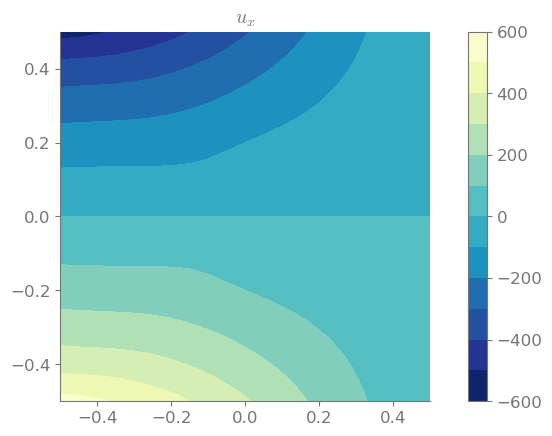

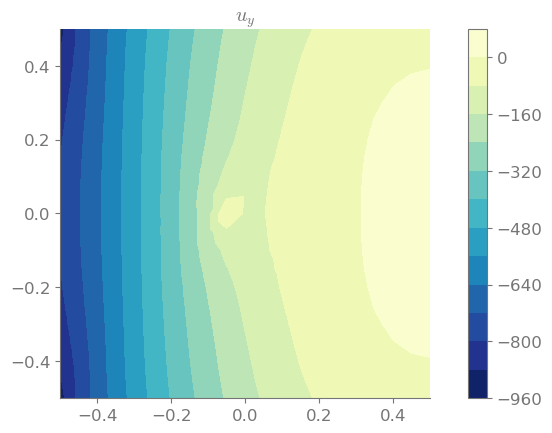

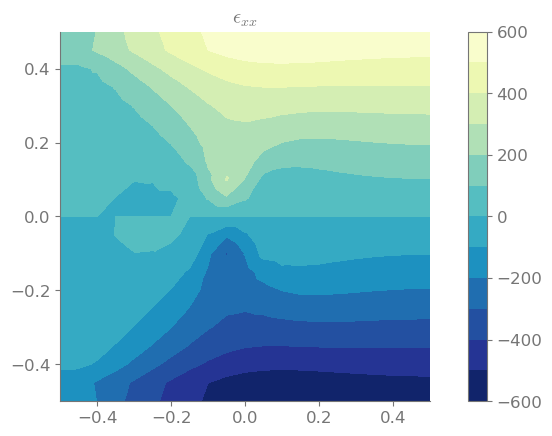

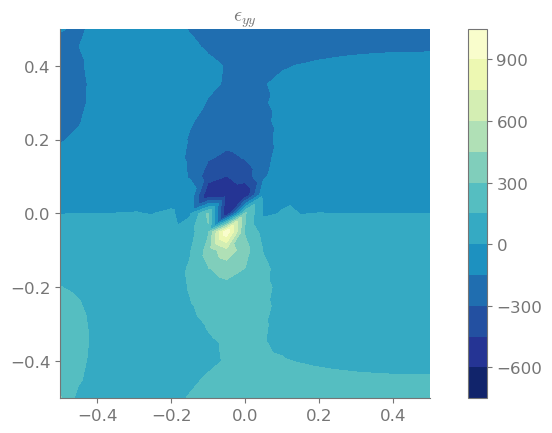

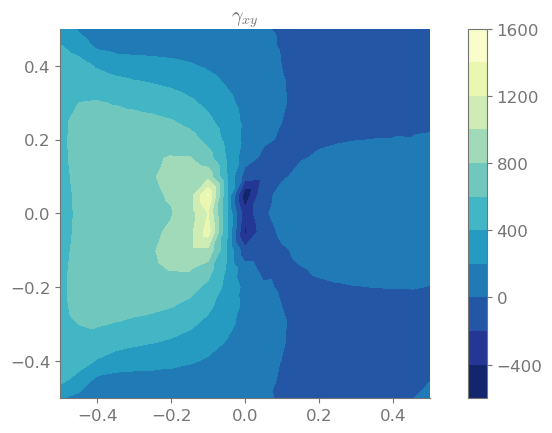

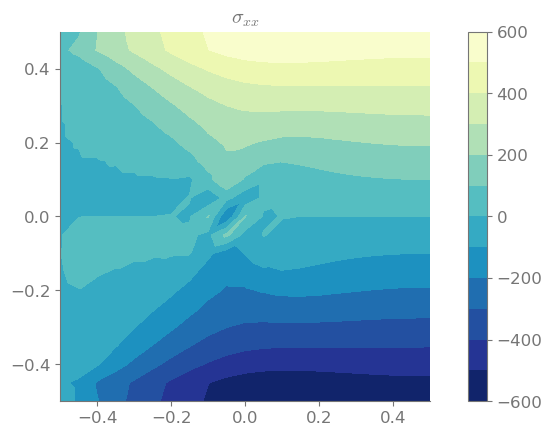

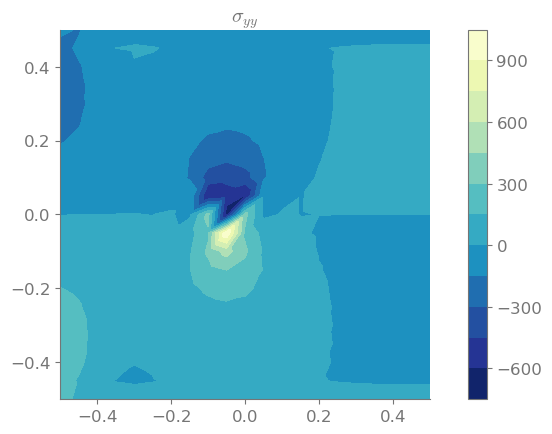

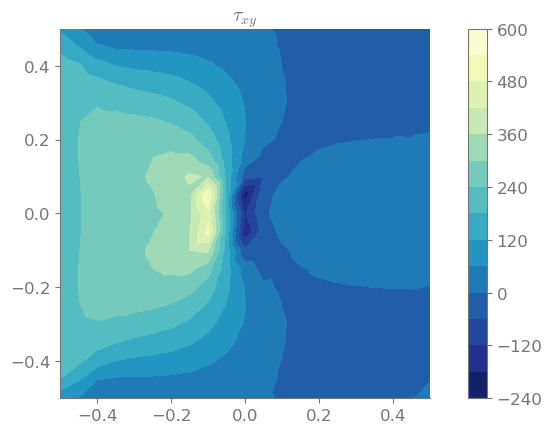

In [3]:
disp, strains, stresses = solids_GUI(True, True, './files2/')

In [16]:
print(stresses.shape)
iter = 5
for _ in range(iter):
    print('hola')

(441, 3)


IndexError: index 3 is out of bounds for axis 1 with size 3